In [1]:
# We implement a simple conv net using tensor flow and test it on the CIFAR 10 dataset. 
%matplotlib inline
import pickle 
import os
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
cifar_10_dataset_folder_path = 'cifar-10-batches-py'

In [2]:
cwd = os.getcwd()
cwd

'/Users/stefan/Python_notebooks'

In [3]:
def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        if sys.version_info[0] < 3:
            dict = pickle.load(f)
        else:
            dict = pickle.load(f, encoding='latin1')
    x = dict['data']
    y = dict['labels']
    x = x.astype(float)
    y = np.array(y)
    return x, y

def load_data():
    xs = []
    ys = []
    
    for i in range(1, 6):
        filename = 'cifar-10-batches-py/data_batch_' + str(i)
        X, Y = load_cifar10_batch(filename)
        xs.append(X)
        ys.append(Y)
    x_train = np.concatenate(xs)/np.float(255)
    x_train = np.dstack((x_train[:, :1024], x_train[:, 1024:2048], x_train[:, 2048:]))
    x_train_full = x_train.reshape((x_train.shape[0], 32, 32, 3))
    x_train = x_train_full[:40000]
    x_val = x_train_full[40000:]
    y_train_full = np.concatenate(ys).astype(np.int32)
    y_train = y_train_full[:40000]
    y_val = y_train_full[40000:50000]
    del xs, ys
    return x_train, x_val, y_train, y_val

In [4]:
# Loads training and validation data sets which are normalized to unity. Still need to zero mean and divide by stddev,
# but this is done separately on datasets. 
x_train, x_val, y_train, y_val = load_data()
len(y_val)

10000

In [5]:
# Randomly shuffle dataset. 
np.random.randint(42)
idx = np.random.permutation(40000)
x_train = x_train[idx]
y_train = y_train[idx]

In [6]:
len(y_train)

40000

In [7]:
y_train[1:20]

array([8, 2, 5, 1, 0, 9, 7, 7, 5, 1, 2, 6, 9, 8, 2, 9, 4, 6, 9], dtype=int32)

In [8]:
width = 32
height = 32
depth = 3
print(x_train.shape)

(40000, 32, 32, 3)


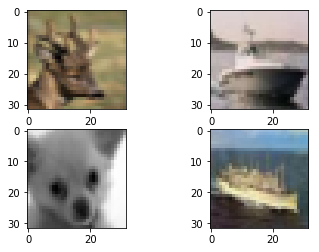

In [9]:
fig = plt.figure()
idx = np.random.randint(40000, size = [2, 2])
plt.subplot(221)
plt.imshow(x_train[idx[0, 0]].transpose((0, 1, 2)), interpolation = 'nearest') 
plt.subplot(222)
plt.imshow(x_train[idx[0, 1]].transpose((0, 1, 2)), interpolation = 'nearest') 
plt.subplot(223)
plt.imshow(x_train[idx[1, 0]].transpose((0, 1, 2)), interpolation = 'nearest') 
plt.subplot(224)
plt.imshow(x_train[idx[1, 1]].transpose((0, 1, 2)), interpolation = 'nearest')         
#idx[4, 4]
#one_image = x_train[1000].transpose((0, 1, 2))
#plt.imshow(one_image, interpolation='nearest')

In [10]:
# Next we scale and zero mean the training and validation images, and implement batch norm
x_val_zero_mean = (x_val - np.mean(x_val, keepdims = True))/np.std(x_val, keepdims = True)
print(x_val_zero_mean.shape, np.mean(x_val_zero_mean),np.std(x_val_zero_mean))

(10000, 32, 32, 3) -3.5516478647e-15 1.0


In [11]:
batch_size = 100
n_batches = int(x_train.shape[0]/batch_size)
print(n_batches)

400


In [12]:
def fetch_batch(epoch, batch_num, batch_size):
    np.random.seed(epoch*n_batches + batch_num)
    batch_idx = np.random.randint(40000, size = batch_size)
    x_batch = x_train[batch_idx]
    x_batch_zeromean = (x_batch - np.mean(x_batch, keepdims = True))/np.std(x_batch, keepdims = True)
    y_batch = y_train[batch_idx]
    return x_batch_zeromean, y_batch

(fetch_batch(1, 1, 100)[1])[:10]
print(np.std(fetch_batch(1, 1, 100)[0]))

1.0


In [14]:
# Now we can write a CNN to train the dataset. Later on to improve training,
# we will augment the dataset by random rotations/permutations. 
import tensorflow as tf
X = tf.placeholder(tf.float32, shape = (None, width, height, depth), name = "X")
y = tf.placeholder(tf.int32, shape = (None), name = "y")

In [13]:
# 3 convolutional and pooling layers -- then flatten the pool and feed to 2 fully connected nets. 

def build_cnn(inputs, labels, learning_rate):    
    #print('building net') 
    weights = {
        'w1': tf.Variable(tf.random_normal([5, 5, 3, 6], stddev = 0.1)), # 5 x 5 is filter size, depth = 3 and #feature maps = 100
        'w2': tf.Variable(tf.random_normal([5, 5, 6, 16], stddev = 0.1)),
        'w3': tf.Variable(tf.random_normal([4, 4, 16, 32], stddev = 0.1))
    }
    
    biases = {
        'b1': tf.Variable(tf.random_normal([6], stddev = 0.1)),
        'b2': tf.Variable(tf.random_normal([16], stddev = 0.1)),
        'b3':tf.Variable(tf.random_normal([32], stddev = 0.1))
    }
    
    conv1 = tf.nn.conv2d(inputs, weights['w1'], strides = [1, 1, 1, 1], padding = "SAME")
    conv1 = tf.nn.bias_add(conv1, biases['b1'])
    conv1 = tf.nn.relu(conv1) # tf.nn.conv2d has no explicit activation fn. Use tf.nn.layers instead. 
    pool1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID")
    
    #image_size = (32 - 2+0)/2+1 = 16 by 16
    conv2 = tf.nn.conv2d(pool1, weights['w2'], strides = [1, 1, 1, 1], padding = "SAME")
    conv2 = tf.nn.bias_add(conv2, biases['b2'])
    conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID")
    
    #image_size = (16 - 2+0)/2+1 = 8 by 8
    conv3 = tf.nn.conv2d(pool2, weights['w3'], strides = [1, 1, 1, 1], padding = "SAME")
    conv3 = tf.nn.bias_add(conv3, biases['b3'])
    conv3 = tf.nn.relu(conv3)
    pool3 = tf.nn.max_pool(conv3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "VALID")
    
    #print('evaluate net')          
    #image_size = (8-2+0)/2+1 = 4 by 4 (depth dimension always unaffected)
    #convert to a dense network at the end for outputing to softmax.
    pool_size = pool3.get_shape().as_list() # use get_shape to get shape of tensor.
    
    pool_flat = tf.reshape(pool3, [-1, pool_size[1]*pool_size[2]*pool_size[3]])
    dense = tf.layers.dense(pool_flat, units = 120, activation = tf.nn.relu)
    logits = tf.layers.dense(dense,  units = 10, activation = None)
    # Use the logits to get the accuracy. 
    
    
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels =labels, logits = logits)
    loss = tf.reduce_mean(xentropy, name = "loss")
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    tf.train.Saver()
    return conv1, loss, logits
    # here the in_top_k function checks if the largest logit is in the top 1 class. 
    #correct = tf.nn.in_top_k(logits, y, 1)
    #accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    

In [17]:
import time
n_epochs = 1
# train for different hyperparameters
#hplist = [0.0001, 0.001, 0.01, 0.1]
acc_tab = np.zeros((int(n_batches/2)), dtype = float)

with tf.Session() as sess:
    start_time = time.time()
#    for hpiter in range(3):
    for iteration in range(int(n_batches/2)):
        X_mybatch, y_mybatch = fetch_batch(1, iteration, batch_size)
        cnn_res = build_cnn(X_mybatch.astype('float32'), y_mybatch, 0.01)
        init = tf.global_variables_initializer()
        sess.run(init)
        conv1, pool_layer, logits = sess.run(cnn_res)
        #print('doing something')
        correct = tf.nn.in_top_k(logits, y_mybatch, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        if iteration % 10 == 0:
            print('doing stuff', iteration)
        acc_tab[iteration] = accuracy.eval()    
    acc_train = accuracy.eval()
    print("training accuracy:", acc_train)
    print(time.time() - start_time)

sess.close()
# once more epochs are added we can save the model at checkpoints. 

doing stuff 0
doing stuff 10
doing stuff 20
doing stuff 30
doing stuff 40
doing stuff 50
doing stuff 60
doing stuff 70
doing stuff 80
doing stuff 90
doing stuff 100
doing stuff 110
doing stuff 120
doing stuff 130
doing stuff 140
doing stuff 150
doing stuff 160
doing stuff 170
doing stuff 180
doing stuff 190
training accuracy: 0.07
6271.604499101639


In [ ]:

#plt.subplot(211)
    #plt.imshow(conv1[10][:,:,11].astype(np.uint8), interpolation = 'nearest')
    #plt.subplot(812)
    #plt.imshow(conv1[10][:,:,1].astype(np.uint8), interpolation = 'nearest')
    #plt.subplot(813)
    #plt.imshow(conv1[50][:,:,1].astype(np.uint8), interpolation = 'nearest')
    #plt.subplot(814)
    #plt.imshow(conv1[80][:,:,1].astype(np.uint8), interpolation = 'nearest')
    #plt.colorbar()
    #plt.subplot(212)
    #plt.imshow(X_mybatch[10].transpose((0, 1, 2)), interpolation = 'nearest') 
    #plt.subplot(816)
    #plt.imshow(X_mybatch[10].transpose((0, 1, 2)), interpolation = 'nearest') 
    #plt.subplot(817)
    #plt.imshow(X_mybatch[50].transpose((0, 1, 2)), interpolation = 'nearest') 
    #plt.subplot(818)
    #plt.imshow(X_mybatch[80].transpose((0, 1, 2)), interpolation = 'nearest') 
    #plt.colorbar()
    #sess.run(pool_out)
    #pool_out.getshape()

# we test out this function and see if it outputs a loss.
#init = tf.global_variables_initializer()
#batch_loss = 0

#with tf.Session() as sess:
#    init.run()
#    for epoch in range(1):
#       for iteration in range(int(n_batches/400)): 
#            X_batch, y_batch = fetch_batch(epoch, iteration, batch_size)
#            pool_out = sess.run(exec_fn(X, y), feed_dict = {X: X_batch, y: y_batch})
#            plt.imshow(pool_out[0].astype(np.unit8))
#            print("batchloss:", batch_loss)
    

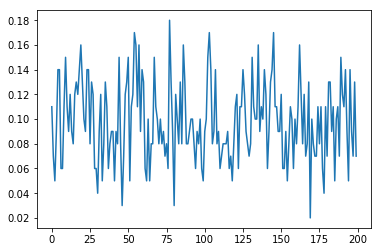

In [18]:
plt.plot(acc_tab)